# CORRESPONDENCE ANALYSIS
## visualisation technique for categorical data
### CA is a visualisation technique that can be applied to categorical data for data exploration. Unlike numerical data, categorical features are harder to analyse and visualise. CA uses a matrix decomposition method, namely SVD, and thus you may see CA being likened to the Principle Components Analysis (PCA). However, CA is not, strictly speaking, a PCA for categorical data, mostly because the primary objective of CA is to provide a visualisation of associations among categorical features.

In [3]:
import pandas as pd
import numpy as np
import itertools

from scipy.stats import chi2_contingency

import seaborn as sns; 
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import geocoder

# Create Sample DataSet
### CA applied to the crime data I used for geo visualisation:

In [8]:
# crime aggregation - see in the Geo Crime Map how to create it
crime = 'crime_agg.csv'
crime_df = pd.read_csv(crime)
# police files folder
police_fold = 'C:\\Datasets\\Crime_UK_2020\\'

In [4]:
crime_df.head()

,Unnamed: 0,Longitude,Latitude,Count,Crime type,MaxCount,maxRatio%
0,0,-8.148313,54.464595,1,Anti-social behaviour,1,100.0
1,1,-8.094473,54.476094,2,Criminal damage and arson,1,50.0
2,2,-8.093664,54.479975,1,Anti-social behaviour,1,100.0
3,3,-8.093111,54.474280,2,Anti-social behaviour,1,50.0
4,4,-8.092119,54.444600,1,Other theft,1,100.0


In [5]:
# list of the police files
def crime_source(police, year, months,police_fold):
    '''
    Need to run only once.
    create the list of the needed police files
    run before: -
    run after: crime_merge
    input: 
    -police: list of the police files
    -year: which year
    -month: months
    '''
    crime_pth = []
    for p in police:
        for y in year:
            for m in months:
                crime_pth.append(police_fold+y+'-'+m+'-'+p+'-street.csv')
    return crime_pth

def crime_merge(crime_pth):
    '''
    Need to run only once.
    Merge all the needed police files
    run before: crime_source
    run after: crime_prep
    '''
    crime_all=pd.DataFrame(columns=['Crime ID','Month','Reported by','Falls within','Longitude',
                               'Latitude','Location','LSOA code','LSOA name','Crime type',
                               'Last outcome category','Context'])
    for i in range(len(crime_pth)):
#        print(i,crime_pth[i] )
        crime_all=crime_all.append(pd.read_csv(crime_pth[i]))
    return crime_all

 
def crime_prep(crime_all): 
    '''
    This function needs to run only once. After that only the rest
    data preparation for all of the processes > before map selection > long but need to run only once
    function before: crime_merge
    function after: nothing in the beginning. crime_loc where locally want a new map
    inputs:
    crime_all before filtering to the box
    outputs:
      print: crime types and frequencies in the box, the most frequent crime scene and the frequncy
      max_crime: (mflong, mflat) > most frequent crime scene coordinates
      loc_freq: crime types and frequencies df
      df5: Main table > sum of crimes by coordinates, plus most common crime at that coordinate and its ratio
    '''
    crime_all1 = crime_all[crime_all.Location != 'No Location']
    print(crime_all.groupby('Crime type').count()[['Month']])
    loc_freq = crime_all.groupby(['Longitude','Latitude']).count()[['Month']]
    print('\nMaximum number of crime in one scene:', loc_freq.max()[0])
    mflong = loc_freq[loc_freq.Month==loc_freq.max()[0]].reset_index().iloc[0,0]
    mflat = loc_freq[loc_freq.Month==loc_freq.max()[0]].reset_index().iloc[0,1]
    print(f'The coordinates of this crime scene:',mflong,mflat)
    max_crime = (mflong, mflat)
    # here I create a table which contains the most frequent crime name and ratio
    df1 = crime_all.groupby(['Longitude','Latitude']).count()[['Month']].reset_index()
    df2 = crime_all.groupby(['Longitude','Latitude','Crime type']).count()[['Month']].reset_index()
    df3 = df2.groupby(['Longitude','Latitude']).max()[['Month']].reset_index()
    df4 = pd.merge(df2, df3,  how='inner', left_on=['Longitude','Latitude','Month'], right_on = ['Longitude','Latitude','Month'])
    df4.drop_duplicates(subset =["Longitude","Latitude"], keep = 'first', inplace = True)
    df4 = df4.rename(columns={"Month": "MaxCount"})

    df5 = pd.merge(df1, df4,  how='inner', left_on=['Longitude','Latitude'], right_on = ['Longitude','Latitude'])
    df5['maxRatio%'] = 100*df5["MaxCount"]/df5["Month"]
    df5 = df5.rename(columns={"Month": "Count"})
    # save the table as it takes forever to run
    df5.to_csv('crime_agg.csv', index = False)
    return max_crime, loc_freq, df5

def mapbox_crime(address,box_size):
    '''based on the address given by geocoder, and manually given box size, calculate the coordinates'''
    long1 = address.lng -box_size[0]
    long2 = address.lng+box_size[0]
    lat1 = address.lat -box_size[1]
    lat2 = address.lat+box_size[1]
    MapBox2 = (long1,long2,lat1,lat2)
    return MapBox2

def crime_loc(df5):
    '''
    needs to be run each time I want to display a new map
    before: need to give the usual things
    after: folium_map2
    input: the crime_prep function third output
    output: the filtered data which now can be displayed on the map
    '''
    print('Number of coordinates in the db:',df5.shape[0])
    df6 = df5[(df5.Longitude>=long1) & (df5.Longitude<=long2) & (df5.Latitude>=lat1) &
                   (df5.Latitude<=lat2)]
    print('Number of coordinates in the box:',df6.shape[0])
    return df6

In [6]:
pol_list = ['avon-and-somerset','bedfordshire','btp','cambridgeshire','cheshire','city-of-london',
'cleveland','cumbria','derbyshire','devon-and-cornwall','dorset','durham',
'dyfed-powys','essex','gloucestershire','gwent','hampshire','hertfordshire',
'humberside','kent','lancashire','leicestershire','lincolnshire','merseyside',
'metropolitan','norfolk','northamptonshire','northern-ireland','northumbria','north-wales',
'north-yorkshire','nottinghamshire','south-wales','south-yorkshire','staffordshire','suffolk',
'surrey','sussex','thames-valley','warwickshire','west-mercia','west-midlands',
'west-yorkshire','wiltshire']

In [9]:
crime_pth = crime_source(police=pol_list, year=['2020'], months=['01','02','03','04'], police_fold=police_fold)
crime_all = crime_merge(crime_pth)

In [10]:
crime_all.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2020-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509384,51.409590,On or near Barnard Walk,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN
1,be92f870c8b560fccc562407cc3537c7e0a2df76c52ef5...,2020-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494870,51.422276,On or near Conference/Exhibition Centre,E01014399,Bath and North East Somerset 001A,Burglary,Under investigation,NaN
2,41bcb7fdf25cf99c5172d22650fe52c2998ceab6225689...,2020-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494870,51.422276,On or near Conference/Exhibition Centre,E01014399,Bath and North East Somerset 001A,Burglary,Under investigation,NaN
3,9bfec6af03a5975f2addc40b93ea4159fdf4dd28dd315c...,2020-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494870,51.422276,On or near Conference/Exhibition Centre,E01014399,Bath and North East Somerset 001A,Other theft,Under investigation,NaN
4,797533a81829551b739cc197a210dd867c3fd35feb74e7...,2020-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494870,51.422276,On or near Conference/Exhibition Centre,E01014399,Bath and North East Somerset 001A,Other theft,Under investigation,NaN


In [13]:
addresses = ['Ashford, Surrey', 'Didcot', 'Basingstoke', 'Newbury', 'Bournemouth', 'York', 'High Wycombe',
             'Bristol', 'Coventry', 'Lynmouth']
address1 = geocoder.osm(addresses[0]+', UK')
address2 = geocoder.osm(addresses[1]+', UK')
address3 = geocoder.osm(addresses[2]+', UK')
address4 = geocoder.osm(addresses[3]+', UK')
address5 = geocoder.osm(addresses[4]+', UK')
address6 = geocoder.osm(addresses[5]+', UK')
address7 = geocoder.osm(addresses[6]+', UK')
address8 = geocoder.osm(addresses[7]+', UK')
address9 = geocoder.osm(addresses[8]+', UK')
address10 = geocoder.osm(addresses[9]+', UK')
print(address1.lng, address1.lat)

-0.4619837 51.4330238


In [24]:
box_size = (0.12,0.1) # shape and size of the crime box (longitude and latitude)
MapBox2 = mapbox_crime(address=address1,box_size=box_size)
long1 = MapBox2[0]
long2 = MapBox2[1]
lat1 = MapBox2[2]
lat2 = MapBox2[3]
crime1 = crime_loc(crime_all)

MapBox2 = mapbox_crime(address=address2,box_size=box_size)
long1 = MapBox2[0]
long2 = MapBox2[1]
lat1 = MapBox2[2]
lat2 = MapBox2[3]
crime2 = crime_loc(crime_all)

MapBox2 = mapbox_crime(address=address3,box_size=box_size)
long1 = MapBox2[0]
long2 = MapBox2[1]
lat1 = MapBox2[2]
lat2 = MapBox2[3]
crime3 = crime_loc(crime_all)

MapBox2 = mapbox_crime(address=address4,box_size=box_size)
long1 = MapBox2[0]
long2 = MapBox2[1]
lat1 = MapBox2[2]
lat2 = MapBox2[3]
crime4 = crime_loc(crime_all)

MapBox2 = mapbox_crime(address=address5,box_size=box_size)
long1 = MapBox2[0]
long2 = MapBox2[1]
lat1 = MapBox2[2]
lat2 = MapBox2[3]
crime5 = crime_loc(crime_all)

MapBox2 = mapbox_crime(address=address6,box_size=box_size)
long1 = MapBox2[0]
long2 = MapBox2[1]
lat1 = MapBox2[2]
lat2 = MapBox2[3]
crime6 = crime_loc(crime_all)

MapBox2 = mapbox_crime(address=address7,box_size=box_size)
long1 = MapBox2[0]
long2 = MapBox2[1]
lat1 = MapBox2[2]
lat2 = MapBox2[3]
crime7 = crime_loc(crime_all)

MapBox2 = mapbox_crime(address=address8,box_size=box_size)
long1 = MapBox2[0]
long2 = MapBox2[1]
lat1 = MapBox2[2]
lat2 = MapBox2[3]
crime8 = crime_loc(crime_all)

MapBox2 = mapbox_crime(address=address9,box_size=box_size)
long1 = MapBox2[0]
long2 = MapBox2[1]
lat1 = MapBox2[2]
lat2 = MapBox2[3]
crime9 = crime_loc(crime_all)

MapBox2 = mapbox_crime(address=address10,box_size=box_size)
long1 = MapBox2[0]
long2 = MapBox2[1]
lat1 = MapBox2[2]
lat2 = MapBox2[3]
crime10 = crime_loc(crime_all)




Number of coordinates in the db: 2031540
Number of coordinates in the box: 33326
Number of coordinates in the db: 2031540
Number of coordinates in the box: 2032
Number of coordinates in the db: 2031540
Number of coordinates in the box: 4410
Number of coordinates in the db: 2031540
Number of coordinates in the box: 1979
Number of coordinates in the db: 2031540
Number of coordinates in the box: 13916
Number of coordinates in the db: 2031540
Number of coordinates in the box: 6428
Number of coordinates in the db: 2031540
Number of coordinates in the box: 5103
Number of coordinates in the db: 2031540
Number of coordinates in the box: 24497
Number of coordinates in the db: 2031540
Number of coordinates in the box: 13485
Number of coordinates in the db: 2031540
Number of coordinates in the box: 25


In [44]:
c1 = crime1.groupby('Crime type').count()[['Month']]
c1.columns = [addresses[0]]

c2 = crime2.groupby('Crime type').count()[['Month']]
c2.columns = [addresses[1]]

c3 = crime3.groupby('Crime type').count()[['Month']]
c3.columns = [addresses[2]]

c4 = crime4.groupby('Crime type').count()[['Month']]
c4.columns = [addresses[3]]

c5 = crime5.groupby('Crime type').count()[['Month']]
c5.columns = [addresses[4]]

c6 = crime6.groupby('Crime type').count()[['Month']]
c6.columns = [addresses[5]]

c7 = crime7.groupby('Crime type').count()[['Month']]
c7.columns = [addresses[6]]

c8 = crime8.groupby('Crime type').count()[['Month']]
c8.columns = [addresses[7]]

c9 = crime9.groupby('Crime type').count()[['Month']]
c9.columns = [addresses[8]]

c10 = crime10.groupby('Crime type').count()[['Month']]
c10.columns = [addresses[9]]



In [47]:
ftable = c1.join(c2).join(c3).join(c4).join(c5).join(c6).join(c7).join(c8).join(c9).join(c10)
ftable = ftable.fillna(0)
ftable

,"Ashford, Surrey",Didcot,Basingstoke,Newbury,Bournemouth,York,High Wycombe,Bristol,Coventry,Lynmouth
Crime type,,,,,,,,,,
Anti-social behaviour,9750,280,748,310,4438,2432,707,5204,2572,6.0
Bicycle theft,304,42,20,24,251,233,39,495,121,0.0
Burglary,1744,122,273,116,675,243,278,1259,929,1.0
Criminal damage and arson,2063,235,417,215,1230,438,466,2134,893,4.0
Drugs,1503,83,131,84,210,154,188,490,231,0.0
Other crime,627,46,73,33,97,74,75,320,249,0.0
Other theft,2352,116,255,141,861,310,420,1673,813,7.0
Possession of weapons,202,18,51,12,54,26,46,137,134,0.0
Public order,1815,111,405,79,542,289,295,2578,759,0.0


### from here correspondence analysis

### Calculate Chi-Squared Statistic

In [55]:
Crosstab = np.array(ftable).T  # np.sum will calculate by cities if df, but hence the total

grandTotal = np.sum(Crosstab)

correspondenceMatrix = np.divide(Crosstab,grandTotal)

rowTotals = np.sum(correspondenceMatrix, axis=1)

columnTotals = np.sum(correspondenceMatrix, axis=0)

In [58]:
print(grandTotal)

105201.0


In [59]:
correspondenceMatrix

array([[9.26797274e-02, 2.88970637e-03, 1.65777892e-02, 1.96100798e-02,
        1.42869364e-02, 5.96001939e-03, 2.23572019e-02, 1.92013384e-03,
        1.72526877e-02, 3.49806561e-03, 1.01710060e-02, 2.95624566e-03,
        3.13875343e-02, 7.52369274e-02],
       [2.66157166e-03, 3.99235749e-04, 1.15968479e-03, 2.23381907e-03,
        7.88965884e-04, 4.37258201e-04, 1.10265112e-03, 1.71101035e-04,
        1.05512305e-03, 7.60449045e-05, 5.89348010e-04, 1.99617874e-04,
        1.20721286e-03, 7.23377154e-03],
       [7.11019857e-03, 1.90112261e-04, 2.59503237e-03, 3.96384065e-03,
        1.24523531e-03, 6.93909754e-04, 2.42393133e-03, 4.84786266e-04,
        3.84977329e-03, 4.56269427e-04, 1.70150474e-03, 2.18629100e-04,
        1.53990932e-03, 1.54466212e-02],
       [2.94674005e-03, 2.28134714e-04, 1.10265112e-03, 2.04370681e-03,
        7.98471497e-04, 3.13685231e-04, 1.34029144e-03, 1.14067357e-04,
        7.50943432e-04, 1.14067357e-04, 1.27375215e-03, 1.52089809e-04,
        1.435

In [61]:
independenceModel = np.outer(rowTotals, columnTotals) # expected dist if independent for the khi square test

### The greater is 𝜒2, the greater is the certainty that the cities crime profile is different.

In [62]:
chiSquaredStatistic = grandTotal*np.sum(np.square(correspondenceMatrix-independenceModel)/independenceModel)
print(chiSquaredStatistic)

6092.383884438052


In [64]:
# Quick check - compare to scipy Chi-Squared test
statistic, prob, dof, ex = chi2_contingency(Crosstab)
print(statistic)
print(np.round(prob, decimals=3))

6092.383884438052
0.0


# Calculating Chi-Squared Distances
#### For the purposes of CA, the differences between the crime profiles of the cities are measured by $\chi^2$ -distances, which are weighted Euclidean distances between normalized rows.

In [66]:
# pre-calculate normalised rows
norm_correspondenceMatrix = np.divide(correspondenceMatrix,rowTotals[:, None])

In [69]:
print(correspondenceMatrix[:3,:5],'\n\n',norm_correspondenceMatrix[:3,:5])

[[0.09267973 0.00288971 0.01657779 0.01961008 0.01428694]
 [0.00266157 0.00039924 0.00115968 0.00223382 0.00078897]
 [0.0071102  0.00019011 0.00259503 0.00396384 0.00124524]] 

 [[0.29256436 0.00912201 0.05233151 0.06190362 0.04509992]
 [0.13779528 0.02066929 0.06003937 0.11564961 0.04084646]
 [0.16961451 0.00453515 0.06190476 0.09455782 0.02970522]]


In [70]:
chiSquaredDistances = np.zeros((correspondenceMatrix.shape[0],correspondenceMatrix.shape[0]))

norm_columnTotals = np.sum(norm_correspondenceMatrix, axis=0)
for row in range(correspondenceMatrix.shape[0]):
    chiSquaredDistances[row]=np.sqrt(np.sum(np.square(norm_correspondenceMatrix
                                                        -norm_correspondenceMatrix[row])/columnTotals, axis=1))

In [71]:
dfchiSquaredDistances = pd.DataFrame(data=np.round(chiSquaredDistances*100).astype(int), columns=addresses)

In [72]:
dfchiSquaredDistances

,"Ashford, Surrey",Didcot,Basingstoke,Newbury,Bournemouth,York,High Wycombe,Bristol,Coventry,Lynmouth
0,0,49,48,42,30,44,39,36,34,100
1,49,0,27,24,49,65,26,38,35,107
2,48,27,0,33,47,63,32,30,32,110
3,42,24,33,0,41,58,21,36,31,101
4,30,49,47,41,0,27,47,35,38,98
5,44,65,63,58,27,0,67,48,59,113
6,39,26,32,21,47,67,0,34,24,99
7,36,38,30,36,35,48,34,0,31,104
8,34,35,32,31,38,59,24,31,0,106
9,100,107,110,101,98,113,99,104,106,0


# Calculating Row Scores

#### CA provides a means of representing a table of $\chi^2$ -distances in a graphical form. This is where the similarity with the PCA analysis comes in. To calculate such representation we need to transform the distances to points in a Cartesian coordinate system. This is achieved by a singular value decomposition (SVD) of a matrix of standardised residuals:

#### We are after the row scores, which are coordinates of points in a high-dimensional space (10 dimensions in this case). These points are arranged so that the Euclidean distance between two points is equal to the $\chi^2$ -distance between the two rows to which they correspond.

In [73]:
standardizedResiduals = np.divide((correspondenceMatrix-independenceModel),np.sqrt(independenceModel))

In [74]:
u,s,vh = np.linalg.svd(standardizedResiduals, full_matrices=False)

In [75]:
deltaR = np.diag(np.divide(1.0,np.sqrt(rowTotals)))

In [76]:
rowScores=np.dot(np.dot(deltaR,u),np.diag(s))

In [78]:
dfFirstTwoComponents = pd.DataFrame(data=[l[0:2] for l in rowScores], columns=['X', 'Y'], index=addresses)

In [79]:
dfFirstTwoComponents

,X,Y
"Ashford, Surrey",0.121465,0.138872
Didcot,-0.248680,-0.004806
Basingstoke,-0.259118,-0.073223
Newbury,-0.165654,0.015747
Bournemouth,0.149832,-0.104388
York,0.310674,-0.237578
High Wycombe,-0.233180,0.112540
Bristol,-0.116623,-0.121202
Coventry,-0.156368,0.077524
Lynmouth,0.052155,0.106903


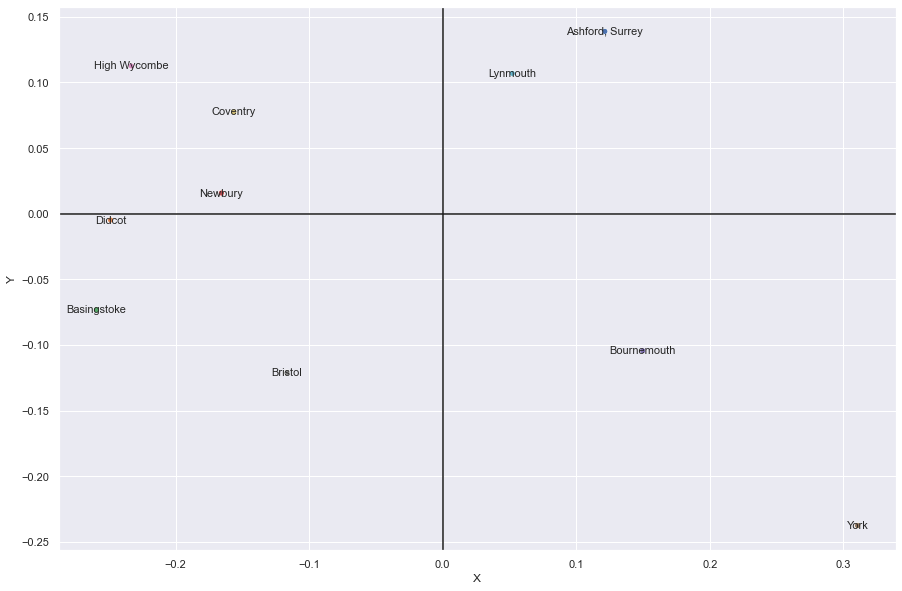

In [84]:
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.scatterplot(data=dfFirstTwoComponents,x='X', y='Y', hue=addresses)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.get_legend().set_visible(False)

for label in addresses:
    plt.annotate(label, 
                 (dfFirstTwoComponents.loc[label,:]['X'],
                  dfFirstTwoComponents.loc[label,:]['Y']),
                 horizontalalignment='center', verticalalignment='center',size=11)

### York and High Wycombe seem the complete opposite

In [91]:
YHW = ftable[['York','High Wycombe']]
YHW

,York,High Wycombe
Crime type,,
Anti-social behaviour,2432,707
Bicycle theft,233,39
Burglary,243,278
Criminal damage and arson,438,466
Drugs,154,188
Other crime,74,75
Other theft,310,420
Possession of weapons,26,46
Public order,289,295


In [92]:
YHW_colsum = np.sum(ftable[['York','High Wycombe']])
YHW_colsum

York            6428
High Wycombe    5103
dtype: int64

In [93]:
np.divide(YHW,YHW_colsum[:, None].T)

,York,High Wycombe
Crime type,,
Anti-social behaviour,0.378345,0.138546
Bicycle theft,0.036248,0.007643
Burglary,0.037803,0.054478
Criminal damage and arson,0.068139,0.091319
Drugs,0.023958,0.036841
Other crime,0.011512,0.014697
Other theft,0.048227,0.082305
Possession of weapons,0.004045,0.009014
Public order,0.044960,0.057809
